In [1]:
# For installation instructions on MIT supercloud, see 
# https://gist.github.com/Sam-2727/3c283bd5d5521bde9742db198f03573e
import gpt as g
import numpy as np
import sys
import io
from os import path
import struct
from typing import Dict, List, Tuple
from xml.etree import ElementTree as ET
# First load matplotlib which we'll need in a bit
import matplotlib.pyplot as plt
import matplotlib as mpl
params = {
    "font.size": 18,
    "legend.fontsize": 18,
    "legend.frameon": False,
    "axes.labelsize": 18,
    "axes.titlesize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "figure.figsize": (8,6),
    'legend.fontsize': '18',
    "xtick.top": False,
    "axes.unicode_minus": False,
    "ytick.right": True,
    "xtick.bottom": True,
    "ytick.left": True,
    "xtick.major.pad": 8,
    "xtick.major.size": 8,
    "xtick.minor.size": 4,
    "ytick.major.size": 8,
    "ytick.minor.size": 4,
    "xtick.direction": "out",
    "ytick.direction": "out",
    "axes.linewidth": 1.5,
    "text.usetex": False,
    "font.family": "serif",
    "font.serif": "cmr10",
    "mathtext.fontset": "cm",
    'figure.dpi': '100',
    "axes.formatter.use_mathtext": True,  # needed when using cm=cmr10 for normal text
}
mpl.rcParams.update(params)
colors = ["#f3dc9a","#da9e6a","#d4d9ae","#d9564a"]

SharedMemoryNone: SharedMemoryAllocate 1073741824 GPU implementation 
0SharedMemoryNone:  SharedMemoryNone.cc acceleratorAllocDevice 1073741824bytes at 0x7f4c54400000 for comms buffers 

__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|_ |  |  |  |  |  |  |  |  |  |  |  | _|__
__|_                                    _|__
__|_   GGGG    RRRR    III    DDDD      _|__
__|_  G        R   R    I     D   D     _|__
__|_  G        R   R    I     D    D    _|__
__|_  G  GG    RRRR     I     D    D    _|__
__|_  G   G    R  R     I     D   D     _|__
__|_   GGGG    R   R   III    DDDD      _|__
__|_                                    _|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
__|__|__|__|__|__|__|__|__|__|__|__|__|__|__
  |  |  |  |  |  |  |  |  |  |  |  |  |  |  


Copyright (C) 2015 Peter Boyle, Azusa Yamaguchi, Guido Cossu, Antonin Portelli and other authors

This program is free software; you can redistribute it and/or modify
it under the t

In [2]:
prop = g.load("sampleProp{}".format(0))
U = g.load("sampleConfigGPT")

GPT :       4.792049 s : Reading sampleProp0
GPT :       4.965483 s : Switching view to [1,1,1,1]/Read
GPT :      19.500037 s : Read 1.42383 GB at 0.0979612 GB/s (0.413251 GB/s for distribution, 0.128398 GB/s for reading + checksum, 20.2549 GB/s for checksum, 1 views per node)
GPT :      19.505468 s : Completed reading sampleProp0 in 14.7155 s
GPT :      19.589827 s : Reading sampleConfigGPT
GPT :      19.690154 s : Switching view to [1,1,1,1]/Read
GPT :      21.212150 s : Read 0.0889893 GB at 0.0584688 GB/s (0.475479 GB/s for distribution, 0.0666672 GB/s for reading + checksum, 19.4714 GB/s for checksum, 1 views per node)
GPT :      22.097729 s : Read 0.0889893 GB at 0.100645 GB/s (27.3362 GB/s for distribution, 0.101017 GB/s for reading + checksum, 20.5669 GB/s for checksum, 1 views per node)
GPT :      22.492571 s : Read 0.0889893 GB at 0.22607 GB/s (20.7164 GB/s for distribution, 0.228568 GB/s for reading + checksum, 33.6958 GB/s for checksum, 1 views per node)
GPT :      22.971141

Recommended reading first: Basic_GPT_Tutorial

# Blocking

We want to covariantly average our propagtor as

(1) $S(\vec{x},t)_{\text{smeared}}=\frac{\alpha}{6}\sum_{\mu}U_{\hat{\mu}}(x)S(\vec{x}+\hat{\mu})+\frac{\beta}{24}\sum_{\mu\neq\mu'}U_{\hat{\mu}}(x)U_{\hat{\mu}'}(x+\hat{\mu})S(\vec{x}+\hat{\mu}+\hat{\mu}')$

The operators we want are $\verb|cov.forward|(\mu)=U_{\hat{\mu}}(x)S(\vec{x}+\hat{\mu})$, $\verb|cov.backward|(\mu)=U_{-\hat{\mu}}(x)S(\vec{x}-\hat{\mu})$ ,where $\verb|cov|$ is shorthand for $\verb|g.covariant.shift(U, boundary_phases=[1,1,1,-1])|$.

The summation of (1) can be implemented as a matrix operator for simplicity, which gpt will evaluate once applying to the propagator. Explicitly, we create an operator $O(\alpha,\beta)$ such that $S_{\text{smeared}}=O(\alpha,\beta)S$

In [3]:
def blockingFirstSecond(Uin,alpha,beta):
    cov = g.covariant.shift(Uin, boundary_phases=[1,1,1,-1])
    # here we define a matrix operator that takes in an object we should dump our blocked propagator in (dst)
    # and a propagator input (src)
    # this is all done implicitly by gpt once applying the operator
    def mat(dst, src):
        assert dst != src
        g.copy(dst, src)
        dst[:] = 0.0
        dimensions = [0,1,2]
        dst+= g.eval(src)
        # do loop over alpha dimensions
        for mu in dimensions:
            dst += g.eval((cov.forward[mu] * src + cov.backward[mu] * src)/6*alpha)
        # do loop over beta dimensions
        for mu in dimensions:
            for nu in dimensions:
                if(mu!=nu):
                    #should be divide by 24, because taking 6 mu!=nu, and then 4 for each mu!=nu
                    dst+=g.eval((cov.forward[nu]*cov.forward[mu]*src+cov.backward[nu]*cov.forward[mu]*src\
                               +cov.forward[nu]*cov.backward[mu]*src+cov.backward[nu]*cov.backward[mu]*src)/24.0*beta)
    return g.matrix_operator(mat=mat)

Once we define a blocking operator, we create a blocking operator explicitly with couplings $\alpha,\beta=1$. We then apply this operator to our propagator. We have to wrap our expression with $\verb|g()|$ for the function to actually evaluate.

In [4]:
blockOperator = blockingFirstSecond(U,1.0,1.0)
blockedPropagator = g(blockOperator*prop)

# Decimation

Now that we have a blocked propagator (more or less a smeared propagator), we want to decimate it. First, we define our coarse grid and coarsening factor ($s$ in the paper).

In [5]:
gridCoarse1 = g.grid([12,12,12,48],precision=g.double)
coarseFactor1 = 2

We then explicitly coarsen our lattice (called decimation in our paper). The most efficient way to do this is to use the $\verb|g.coordinates|$ function, which gets an array of coordinates for the lattice. Then, we just multiply all our coordinates by the corresponding coarsening factor to keep every $n$th coordinate.

In [6]:
def coarsenLattice(coarseGrid,coarseFactor,prop):
    lattCoarse = g.lattice(coarseGrid,prop.otype)
    coarseCoords = g.coordinates(lattCoarse)
    coarseArray = np.array(coarseCoords)
    fineArray = np.copy(coarseArray)
    fineArray[:,0:3]*=coarseFactor
    coarseLattice = g.copy(lattCoarse)
    coarseLattice[coarseArray]=prop[fineArray]
    return coarseLattice

In [7]:
coarsenedProp = coarsenLattice(gridCoarse1,coarseFactor1,prop)

That's basically it! I made things a bit more abstract in the production code so things are more flexible, but this is the core function of the paper. Let's see what the sparsened correlation function looks like

In [8]:
def emMeson(corr):
    corrMean = corr
    E = []
    for i in range(1,len(corrMean)-1):
        E.append(np.arccosh((corrMean[i-1]+corrMean[i+1])/(2*corrMean[i])))
    return np.array(E)
corrPion1 = g.slice(g.trace(prop*g.adj(prop)),3)
corrPion2 = g.slice(g.trace(coarsenedProp*g.adj(coarsenedProp)),3)
effectiveMassPion1 = emMeson(corrPion1)
effectiveMassPion2 = emMeson(corrPion2)

/state/partition1/llgrid/pkg/anaconda/anaconda3-2023a/lib/python3.9/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


(-0.5, 12.0)

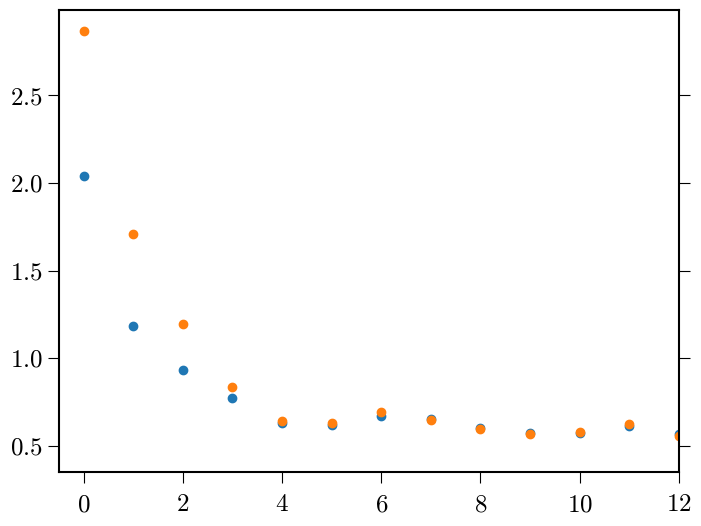

In [9]:
plt.scatter(np.arange(0,46),effectiveMassPion1)
plt.scatter(np.arange(0,46),effectiveMassPion2)
plt.xlim([-0.5,12])


Even for one gauge configuration, we see that the decay is faster for the unsparsened result for one step of blocking, in-line with the results of our paper.

# Multiple steps

In [12]:
blockOperator = blockingFirstSecond(U,1.0,1.0)
blockedPropagator = prop
#might take a bit
for i in range(0,20):
    print(i)
    blockedPropagator = g(blockOperator*blockedPropagator)

coarsenedProp = coarsenLattice(gridCoarse1,coarseFactor1,blockedPropagator)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


Now we see that the correlator has a faster decay, but at the sacrifice of increased noise.

(-0.5, 12.0)

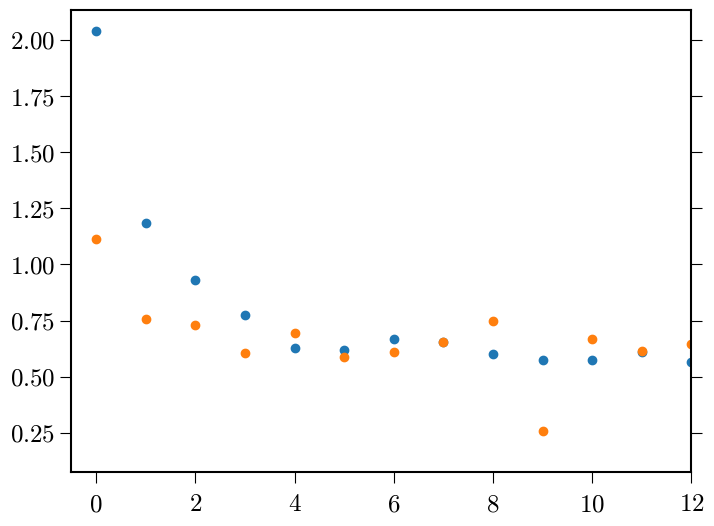

In [13]:
corrPion1 = g.slice(g.trace(prop*g.adj(prop)),3)
corrPion2 = g.slice(g.trace(coarsenedProp*g.adj(coarsenedProp)),3)
effectiveMassPion1 = emMeson(corrPion1)
effectiveMassPion2 = emMeson(corrPion2)
plt.scatter(np.arange(0,46),effectiveMassPion1)
plt.scatter(np.arange(0,46),effectiveMassPion2)
plt.xlim([-0.5,12])